In [86]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import calendar
from scipy.interpolate import spline

In [112]:
source="D:\\data analytics\\S2\\Ml lab\\dataset\\energy prediction\\"
solution="D:\\data analytics\\S2\\Ml lab\\dataset\\energy prediction\\GEFCOM2012_Data\\Load\\"
train_load="D:\\data analytics\\S2\\Ml lab\\dataset\\energy prediction\\Load_history.csv"
train_temp="D:\\data analytics\\S2\\Ml lab\\dataset\\energy prediction\\temperature_history.csv"
test_val="D:\\data analytics\\S2\\Ml lab\\dataset\\energy prediction\\test.csv"
test_weights="D:\\data analytics\\S2\\Ml lab\\dataset\\energy prediction\\weights.csv"
holiday="D:\\data analytics\\S2\\Ml lab\\dataset\\energy prediction\\GEFCOM2012_Data\\Load\\Holiday_List.csv"
load_soln="D:\\data analytics\\S2\\Ml lab\\dataset\\energy prediction\\GEFCOM2012_Data\\Load\\Load_solution.csv"
temp_soln="D:\\data analytics\\S2\\Ml lab\\dataset\\energy prediction\\GEFCOM2012_Data\\Load\\temperature_solution.csv"
benchmark="D:\\data analytics\\S2\\Ml lab\\dataset\\energy prediction\\GEFCOM2012_Data\\Load\\Load_benchmark.csv"

# Pre-processing

In [88]:
sln_df=pd.read_csv(load_soln)

In [121]:
bm_df=pd.read_csv(benchmark)
load_df=pd.read_csv(train_load)
temp_df=pd.read_csv(train_temp)

In [90]:
print(load_df.shape)

(33000, 28)


In [91]:
#add consolidated date column by combining year , month and day
weekdays=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
load_df['date']=load_df.apply(lambda row: str(row['year'])+"-"+str(row['month']).zfill(2)+"-"+str(row['day']).zfill(2),axis=1)
days=load_df.apply(lambda row: datetime.date(row['year'], row['month'], row['day']).strftime("%A"),axis=1)
# cat=pd.Categorical(days,categories=weekdays,ordered=True)
# load_df['day name']=cat
load_df['day name']=days
load_df.head()

,zone_id,year,month,day,h1,h2,h3,h4,h5,h6,...,h17,h18,h19,h20,h21,h22,h23,h24,date,day name
0,1,2004,1,1,"16,853","16,450","16,517","16,873","17,064","17,727",...,"14,130","16,809","18,150","18,235","17,925","16,904","16,162","14,750",2004-01-01,Thursday
1,1,2004,1,2,"14,155","14,038","14,019","14,489","14,920","16,072",...,"15,839","17,727","18,895","18,650","18,443","17,580","16,467","15,258",2004-01-02,Friday
2,1,2004,1,3,"14,439","14,272","14,109","14,081","14,775","15,491",...,"13,826","15,825","16,996","16,394","15,406","14,278","13,315","12,424",2004-01-03,Saturday
3,1,2004,1,4,"11,273","10,415","9,943","9,859","9,881","10,248",...,"14,162","16,237","17,430","17,218","16,633","15,238","13,580","11,727",2004-01-04,Sunday
4,1,2004,1,5,"10,750","10,321","10,107","10,065","10,419","12,101",...,"15,501","17,307","18,786","19,089","19,192","18,416","17,006","16,018",2004-01-05,Monday


In [92]:
def get_score_from_sum(x):
    return round(math.sqrt(x))

def get_scores(test_df):
    weight_array=np.array(sln_df['weight'])
    diff_dict={}
    for i in range (1,25):
        hour="h"+str(i)
        sln_array=np.float_(list(sln_df[hour]))
        test_array=np.float_(list(test_df[hour]))
        #(act-model)^2
        diff_square=np.square(sln_array-test_array)
        diff_dict[hour]=diff_square
    diff_df=pd.DataFrame.from_dict(diff_dict)
    diff_df['weight']=sln_df['weight']
    
    #get backcast diff (backcast weight are 1 and 20)
    backcast_df=diff_df[(diff_df['weight']==1) | (diff_df['weight']==20)]
    #sum of backcast weights (multiply by 24 because each row has 24 values)
    bc_sum_weights=backcast_df['weight'].sum() * 24   
    #get wi/sum(wi) for each backcast weight wi
    bc_weight_array=np.true_divide(np.array(backcast_df['weight']),bc_sum_weights)
    
    #get forecast weight array and sum of weights
    forecast_df=diff_df[(diff_df['weight']==8) | (diff_df['weight']==160)]
    fc_sum_weights=forecast_df['weight'].sum() * 24   
    fc_weight_array=np.true_divide(np.array(forecast_df['weight']),fc_sum_weights)
    
    #get total weight array and sum of weights
    tot_sum_weights=sln_df['weight'].sum()*24
    tot_weight_array=np.true_divide(np.array(sln_df['weight']),tot_sum_weights)
    
    fc_sum=0.0
    bc_sum=0.0
    tot_sum=0.0
    for i in range(1,25):
        hour="h"+str(i)
        #find (wi/sum(wi)) * sum((act-obtained)^2) for each hour
        bc_weighed_array=np.array(backcast_df[hour])*bc_weight_array
        fc_weighed_array=np.array(forecast_df[hour])*fc_weight_array
        tot_weighed_array=np.array(diff_df[hour])*tot_weight_array
        bc_sum +=bc_weighed_array.sum()
        fc_sum +=fc_weighed_array.sum()
        tot_sum +=tot_weighed_array.sum()
    bc_score=get_score_from_sum(bc_sum)
    fc_score=get_score_from_sum(fc_sum)
    tot_score=get_score_from_sum(tot_sum)    
    return bc_score,fc_score,tot_score
#find scores of benchmark
bm_scores=get_scores(bm_df)
print(bm_scores)

(69557, 123758, 100385)


In [93]:
rows_with_nan=load_df[load_df.isnull().any(axis=1)]
print("size of rows with nan : ",rows_with_nan.shape)
days_with_nan=set(list(rows_with_nan['date']))
print(days_with_nan)


size of rows with nan :  (1280, 30)
{'2005-06-23', '2005-09-10', '2008-07-06', '2006-05-30', '2008-06-30', '2006-05-31', '2005-03-12', '2006-11-28', '2006-02-14', '2006-02-15', '2006-02-18', '2005-06-26', '2005-06-21', '2006-02-16', '2006-02-19', '2005-09-16', '2005-03-10', '2005-06-25', '2005-12-25', '2008-07-02', '2006-08-05', '2008-07-01', '2008-07-05', '2006-02-13', '2006-08-06', '2005-06-24', '2005-09-15', '2008-07-04', '2006-11-24', '2006-08-04', '2008-07-07', '2006-08-07', '2005-09-12', '2005-06-22', '2006-11-27', '2005-03-08', '2005-06-20', '2005-12-27', '2006-11-22', '2006-08-08', '2005-03-09', '2006-08-03', '2006-11-23', '2005-09-14', '2005-12-26', '2005-12-30', '2005-12-28', '2006-05-28', '2008-07-03', '2005-12-31', '2006-05-27', '2006-11-25', '2006-02-17', '2006-05-29', '2006-05-26', '2006-08-02', '2005-09-11', '2005-03-11', '2006-05-25', '2005-12-29', '2005-03-07', '2005-03-06', '2005-09-13', '2006-11-26'}


In [94]:
partial_data_rows=rows_with_nan[rows_with_nan.filter(regex='h[0-9]+',axis=1).notnull().any(1)]
print(set(list(partial_data_rows['date'])))

{'2008-06-30'}


Found days with nan values
These are the values that should be predicted by model

In [95]:
#get non null rows
train_df=load_df[~load_df.isnull().any(axis=1)]
#convert values to numeric
hours=["h"+str(hour) for hour in range(1,25)]
for col in hours:
    train_df[col]=train_df[col].apply(lambda x:x.replace(",",""))
    train_df[col]=pd.to_numeric(train_df[col])


C:\Users\dell\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\dell\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [96]:
# train_df['total']=train_df.apply(lambda row: row[hours].sum()/1000000,axis=1)
# train_df.head()
# train_df[hours].sum(axis=1)/1000000
train_df['total']=train_df[hours].sum(axis=1)/1000000

C:\Users\dell\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


## Plot for each zone

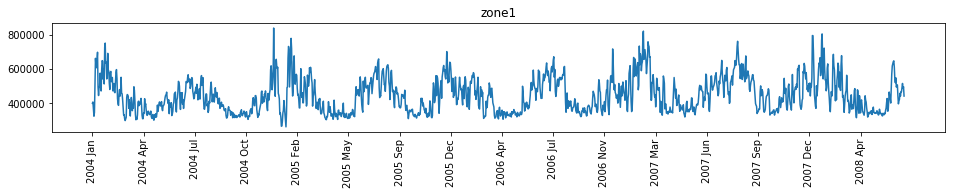

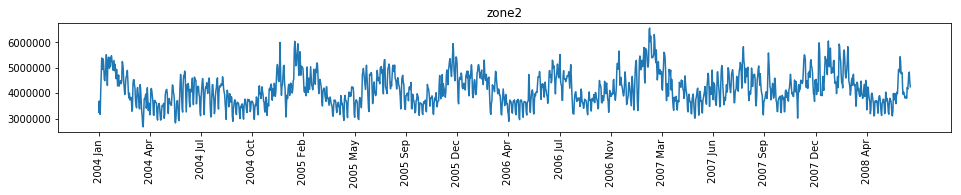

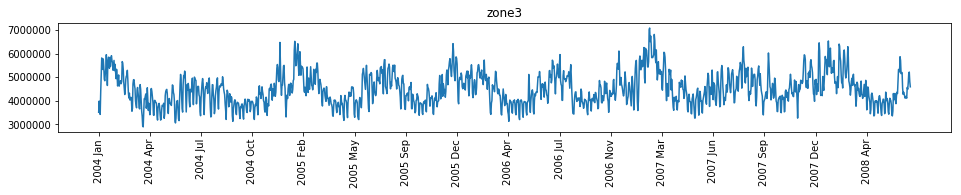

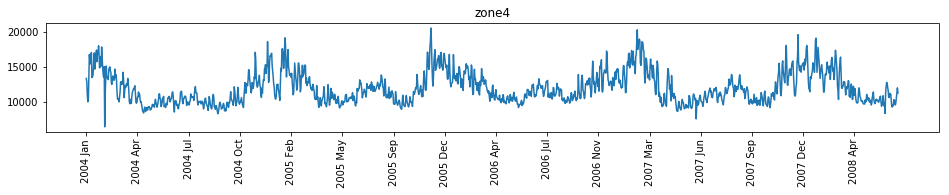

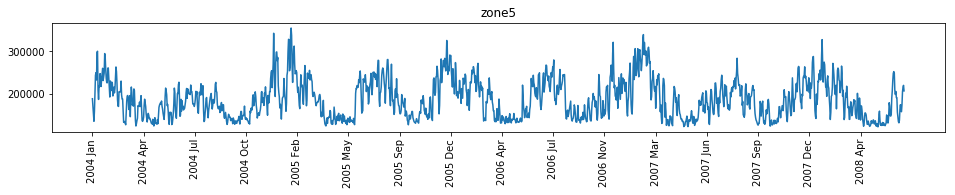

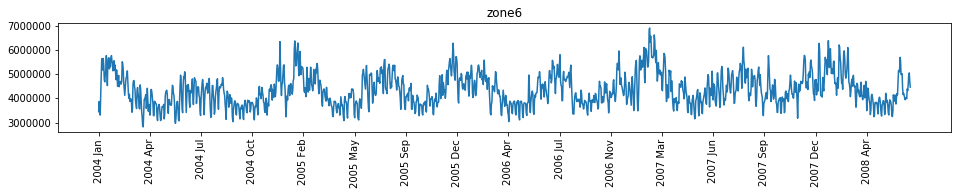

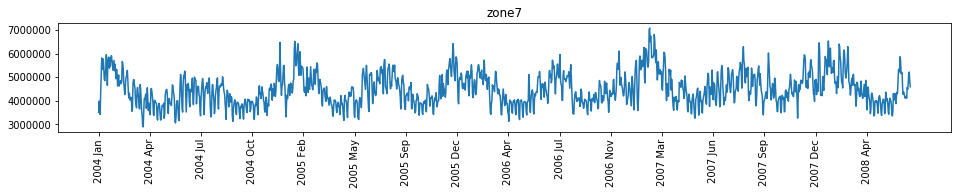

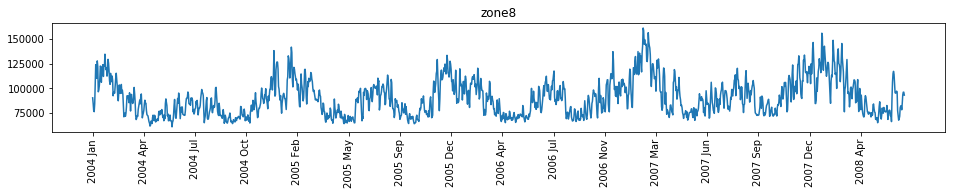

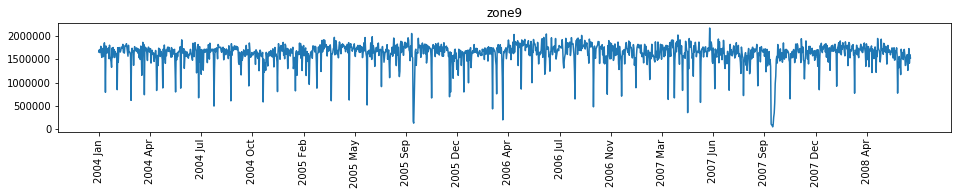

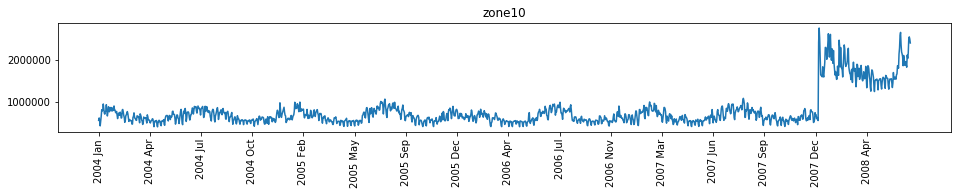

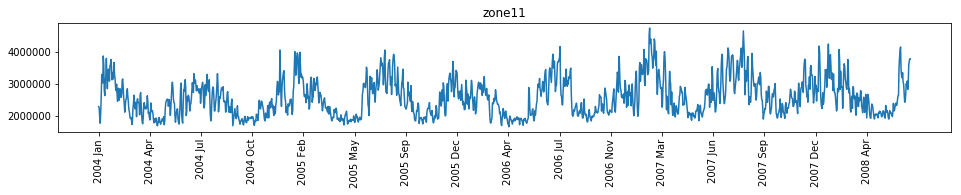

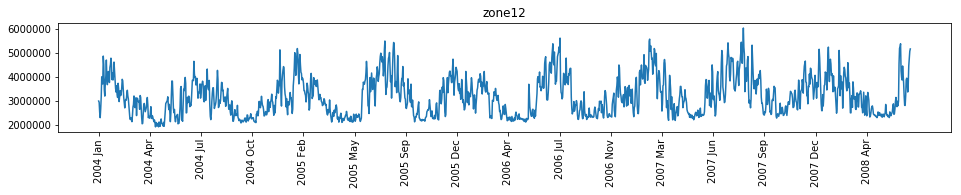

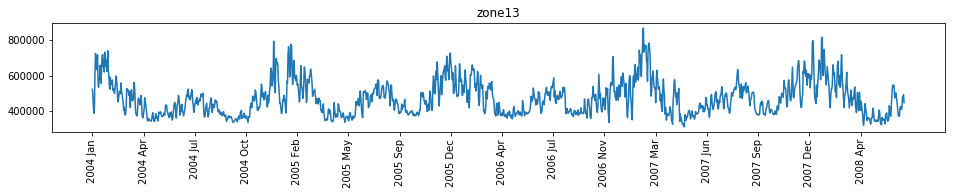

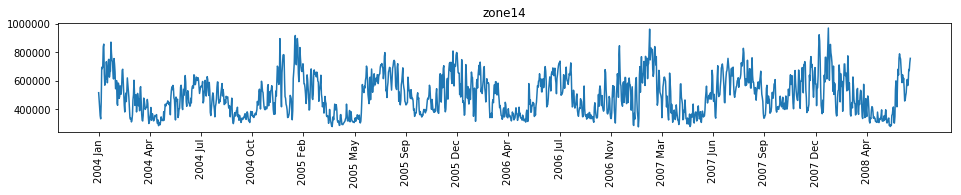

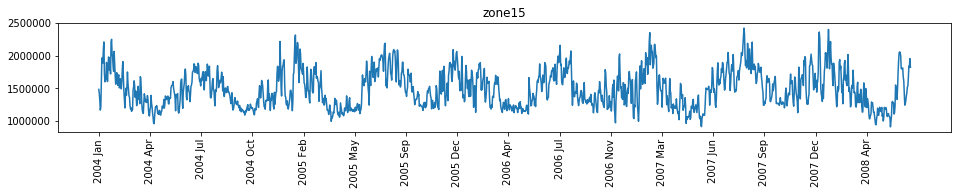

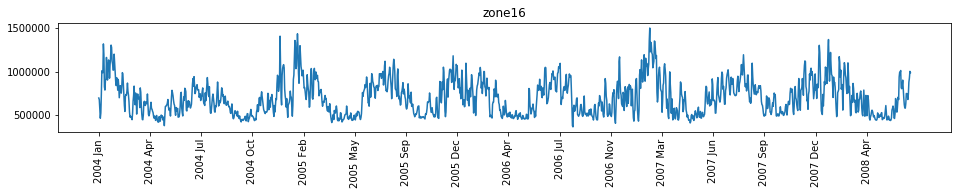

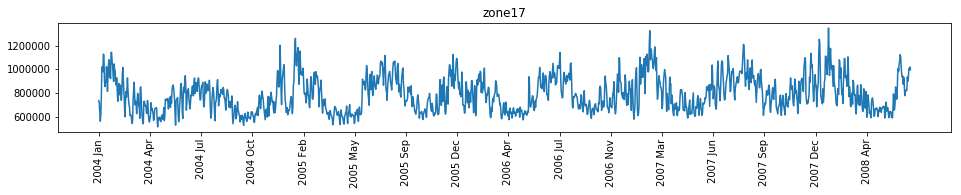

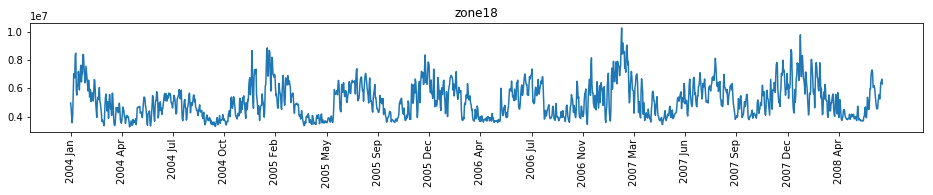

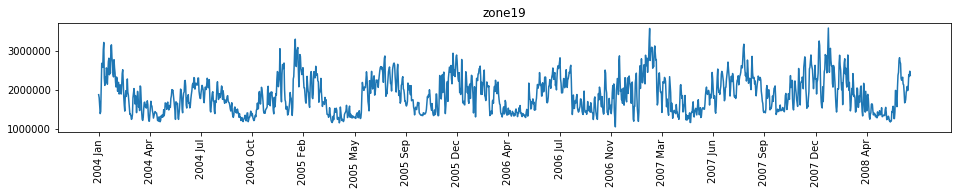

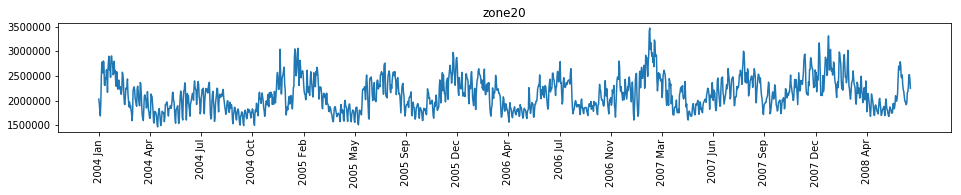

In [97]:
for zone in range(1,21):
    plt.figure(figsize=(16, 2))
    zone_df=train_df[(train_df['zone_id']==zone)]
#     zone_df['date']
    l1=np.array(zone_df['total'])*1000000
    l2=zone_df.apply(lambda row: datetime.date(row['year'], row['month'], row['day']).strftime("%Y %b"),axis=1)
    plt.plot(l1)
    plt.title("zone" + str(zone))
    plt.xticks(range(0,len(l1),100),l2[::100],rotation=90)
    plt.show()
    

C:\Users\dell\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
C:\Users\dell\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


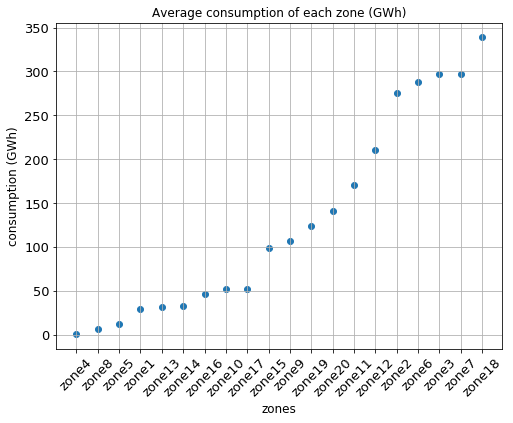

In [98]:
#average of each zones
zone_avg_dict={}
for zone in range(1,21):
    zone_df=train_df[(train_df['zone_id']==zone)]
    zone_df=zone_df[hours]
    #get sum of hourly loads in kW
    sum_list=np.array(zone_df.sum(axis = 0, skipna = True))
    #total sum
    sum=np.sum(sum_list)
    #divide by 10^6*24 to get gWh value
    sum_gwh=sum/(math.pow(10,6)*24)
    zone_avg_dict["zone"+str(zone)]=sum_gwh
# plt.plot(range(1,21),zone_avg.values(), 'ro')
# plt.xticks(range(len(zone_avg)), list(zone_avg.keys()), rotation=45)
# plt.show()
plt.figure(figsize=(8, 6))
lists = sorted(zone_avg_dict.items(), key=lambda kv: kv[1]) # sorted by key, return a list of tuples
x, y = zip(*lists) # unpack a list of pairs into two tuples
plt.title("Average consumption of each zone (GWh)")
plt.xlabel("zones",fontsize=12)
plt.ylabel("consumption (GWh)",fontsize=12)
plt.scatter(x,y)
plt.tick_params(axis='both', which='major', labelsize=13)
plt.xticks(rotation=45)
plt.axes().xaxis.grid()
plt.axes().yaxis.grid()
plt.show()

In [99]:

# for day in weekdays:
#     day_df=train_df[train_df['day name']==day]
agg_df=train_df.groupby(['year','month','day','date','day name']).sum().reset_index()
agg_df=agg_df.drop(['zone_id'],axis=1)

In [100]:
print(agg_df.shape)

(1586, 30)


Text(0,0.5,'Toal (GW)')

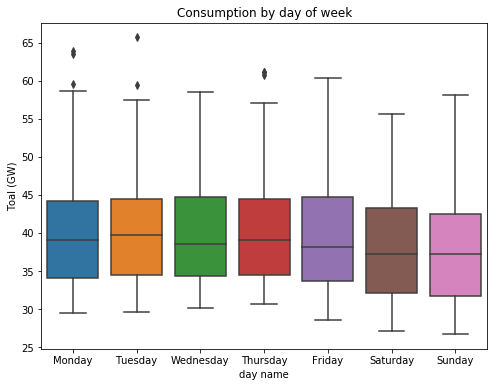

In [101]:
plt.figure(figsize=(8, 6))
plt.title("Consumption by day of week")
sns.boxplot(x='day name',y='total',data=agg_df,order=weekdays)
plt.ylabel("Toal (GW)")

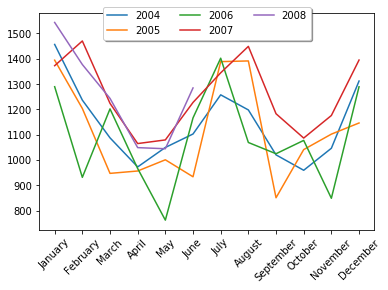

In [102]:
months= [calendar.month_name[i] for i in range (1,13)]
month_agg_df=month_agg_df=train_df.groupby(['year','month']).sum()
month_agg_df=month_agg_df.reset_index()
for year in month_agg_df['year'].unique():
    sub_df=month_agg_df[month_agg_df['year']==year]
    plt.plot(list(sub_df['month']),list(sub_df['total']),label=year)
    plt.xticks(range(1,13),months,rotation=45)
# plt.legend(loc='upper left')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True)
plt.show()

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24]), <a list of 24 Text xticklabel objects>)

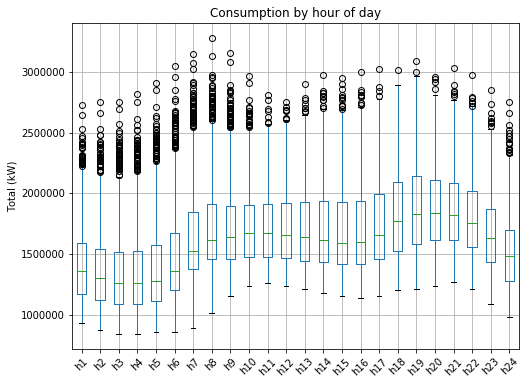

In [103]:
plt.figure(figsize=(8, 6))
plt.title("Consumption by hour of day")
# sns.boxplot(x='day name',y='total',data=agg_df,order=weekdays)
agg_df.boxplot(column=hours)
plt.ylabel("Total (kW)")
plt.xticks(rotation=45)

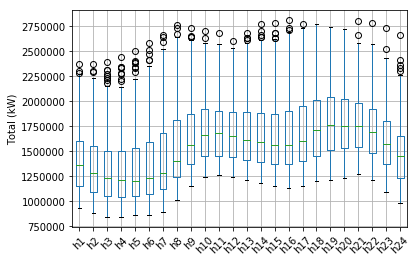

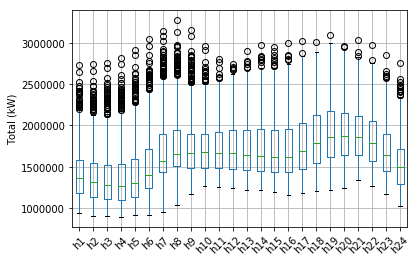

In [104]:
#split by week days
agg_df_weekends=agg_df[(agg_df['day name']=='Sunday') | (agg_df['day name']=='Saturday')]
agg_df_weekdays=agg_df[(agg_df['day name']!='Sunday') & (agg_df['day name']!='Saturday')]
# plt.title("Consumption by hour of day in weekends")
agg_df_weekends.boxplot(column=hours)
plt.ylabel("Total (kW)")
plt.xticks(rotation=45)
# plt.title("Consumption by hour of day in week days")
plt.show()
agg_df_weekdays.boxplot(column=hours)
plt.ylabel("Total (kW)")
plt.xticks(rotation=45)
plt.show()

In [171]:
temp_df=pd.read_csv(train_temp)
print(temp_df.shape)
temp_df['date']=temp_df.apply(lambda row: str(int(row['year']))+"-"+str(int(row['month'])).zfill(2)+"-"+str(int(row['day'])).zfill(2),axis=1)
#farenheit to celcius
for col in hours:
    temp_df[col]=temp_df[col].apply(lambda x:round((x-32)*(5/9),2))

(18073, 28)


In [172]:
temp_df.head()

,station_id,year,month,day,h1,h2,h3,h4,h5,h6,...,h16,h17,h18,h19,h20,h21,h22,h23,h24,date
0,1,2004,1,1,7.78,7.78,7.22,5.00,3.89,1.67,...,12.78,11.11,7.78,4.44,4.44,3.89,3.33,4.44,5.00,2004-01-01
1,1,2004,1,2,6.11,6.67,7.78,7.78,8.33,8.33,...,13.33,13.89,11.67,10.00,8.33,7.78,7.22,7.22,7.22,2004-01-02
2,1,2004,1,3,7.22,7.78,7.78,6.67,6.11,7.78,...,20.00,20.00,18.33,17.78,17.22,16.67,17.22,17.22,16.67,2004-01-03
3,1,2004,1,4,17.22,16.67,16.67,16.67,15.56,15.56,...,22.22,21.67,20.00,19.44,19.44,18.33,17.78,18.33,17.78,2004-01-04
4,1,2004,1,5,17.78,17.22,18.33,17.78,17.78,17.78,...,18.89,18.89,18.89,17.22,12.22,11.11,9.44,8.33,8.33,2004-01-05


In [173]:
temp_df.station_id.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11], dtype=int64)

In [174]:
rows_with_nan=temp_df[temp_df.isnull().any(axis=1)]
print("size of rows with nan : ",rows_with_nan.shape)
days_with_nan=set(list(rows_with_nan['date']))
print(days_with_nan)
#get non null rows
tmp_train_df=temp_df[~temp_df.isnull().any(axis=1)]

size of rows with nan :  (11, 29)
{'2008-06-30'}


In [175]:
tmp_train_df.shape

(18062, 29)

In [176]:
tmp_train_df['average']=tmp_train_df[hours].mean(axis=1)
print(tmp_train_df.head())
print(max(tmp_train_df['average']))

   station_id  year  month  day     h1     h2     h3     h4     h5     h6  \
0           1  2004      1    1   7.78   7.78   7.22   5.00   3.89   1.67   
1           1  2004      1    2   6.11   6.67   7.78   7.78   8.33   8.33   
2           1  2004      1    3   7.22   7.78   7.78   6.67   6.11   7.78   
3           1  2004      1    4  17.22  16.67  16.67  16.67  15.56  15.56   
4           1  2004      1    5  17.78  17.22  18.33  17.78  17.78  17.78   

     ...        h17    h18    h19    h20    h21    h22    h23    h24  \
0    ...      11.11   7.78   4.44   4.44   3.89   3.33   4.44   5.00   
1    ...      13.89  11.67  10.00   8.33   7.78   7.22   7.22   7.22   
2    ...      20.00  18.33  17.78  17.22  16.67  17.22  17.22  16.67   
3    ...      21.67  20.00  19.44  19.44  18.33  17.78  18.33  17.78   
4    ...      18.89  18.89  17.22  12.22  11.11   9.44   8.33   8.33   

         date    average  
0  2004-01-01   6.852083  
1  2004-01-02   9.142083  
2  2004-01-03  13.79666

C:\Users\dell\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [204]:
nanset=set(rows_with_nan.date.unique())
set1=set(train_df.date.unique())
set2=set(tmp_train_df.date.unique())
diff=set2.difference(set1)
tempdf_sub= tmp_train_df[~tmp_train_df['date'].isin(diff)]

C:\Users\dell\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\dell\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\dell\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


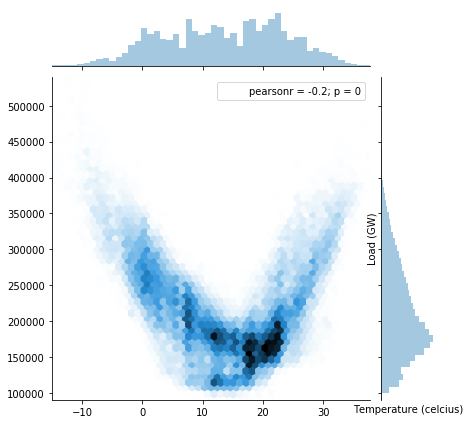

In [207]:
zone_df=train_df[train_df['zone_id']==18]
stn_df= tempdf_sub[tempdf_sub['station_id']==9]
tmp=[]
load=[]
for hour in hours:
    tmp=tmp +list(stn_df[hour])
    load=load + list(zone_df[hour])
tmp=np.array(tmp)
load=np.array(load)
sns.jointplot(tmp,load,kind="hex")
plt.xlabel("Temperature (celcius)")
plt.ylabel("Load (GW)")
plt.show()

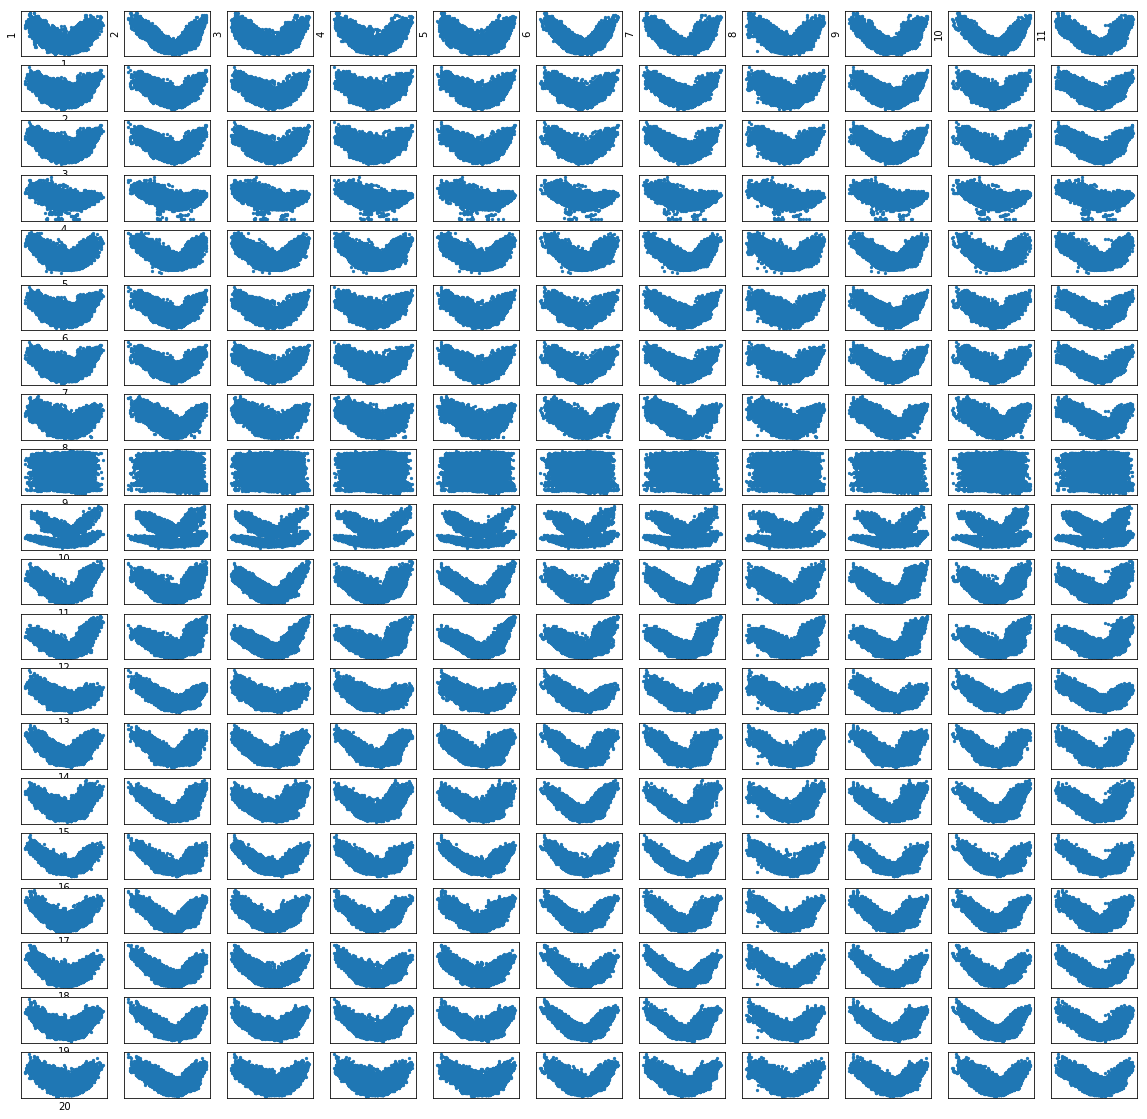

In [210]:

fig,axes=plt.subplots(20,11,figsize=(20,20))
plt.setp(axes, xticks=[],yticks=[])
for zone in range(1,21):
    for stn in range (1,12):
        zone_df=train_df[train_df['zone_id']==zone]
        stn_df= tempdf_sub[tempdf_sub['station_id']==stn]
        tmp=[]
        load=[]
        for hour in hours:
            tmp=tmp +list(stn_df[hour])
            load=load + list(zone_df[hour])
        tmp=np.array(tmp)
        load=np.array(load)
        ax=axes[zone-1,stn-1]
        ax.scatter(tmp,load,s=5)
        if(stn==1):
            ax.set_xlabel(zone)
        if(zone==1):
            ax.set_ylabel(stn)
plt.show()